In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings; warnings.filterwarnings('ignore');
from sklearn.model_selection import GridSearchCV

import XGBBinary as xgbb
import XGBWrapper as xgbw
import xgboost as xgb

from evalutils import testdata
from evalutils import class_report

X_train, X_test, y_train, y_test = testdata(
    n_classes=10,
    n_samples=100000,
    super_class_percent=.3)

gridsearch = {
    'max_depth': [4, 6],
    'n_estimators': [100],
    'learning_rate': [.1, .01, .001],
    'early_stopping_rounds': [5],
    'n_jobs':[4],
}

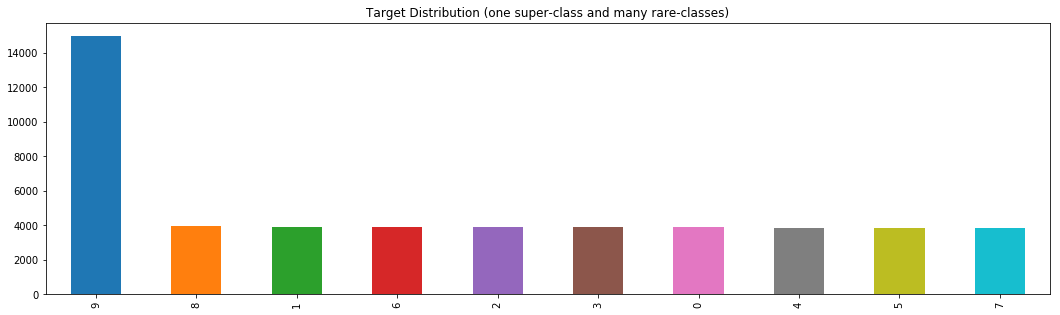

In [2]:
y_train.value_counts().plot(
    kind='bar',
    title='Target Distribution (one super-class and many rare-classes)',
    figsize=(18, 5));

# XGB-Binary

In [3]:
xgb_binary = xgbb.XGBBinary(
    gridsearch=gridsearch,
    gridsearch_n_jobs=4,
    gridsearch_verbose=True,
    test=0.3,
    cross_validation=2,
    performance_politic='f1-score__mean',
    equal_sample=False)

xgb_binary.fit(X_train, y_train)

report_bin = class_report(
        y_true=y_test, 
        y_pred=xgb_binary.predict(X_test))
report_bin

Classifier label 0
Fitting 6 models...

1 of 6 - f1-score__mean: 0.635  - 1.56 s
	early_stopping_rounds: 5
	learning_rate: 0.1
	max_depth: 4
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.89134438305709

2 of 6 - f1-score__mean: 0.6975  - 2.09 s
	early_stopping_rounds: 5
	learning_rate: 0.1
	max_depth: 6
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.89134438305709

3 of 6 - f1-score__mean: 0.555  - 0.62 s
	early_stopping_rounds: 5
	learning_rate: 0.01
	max_depth: 4
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.89134438305709

4 of 6 - f1-score__mean: 0.5925  - 1.42 s
	early_stopping_rounds: 5
	learning_rate: 0.01
	max_depth: 6
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.89134438305709

5 of 6 - f1-score__mean: 0.5625  - 0.47 s
	early_stopping_rounds: 5
	learning_rate: 0.001
	max_depth: 4
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.89134438305709

6 of 6 - f1-score__mean: 0.575  - 0.63 s
	early_stopping_rounds: 5
	learning_rate: 0.001
	max_depth: 6
	n_es

          y  precision  recall  f1-score  support     pred
0         0       0.98    0.93      0.96  13796.0  13049.0
1         1       0.51    0.83      0.63   1204.0   1951.0
Global  all       0.95    0.92      0.93  15000.0  15000.0
-----------------------------
Classifier label 6
Fitting 6 models...

1 of 6 - f1-score__mean: 0.7  - 3.19 s
	early_stopping_rounds: 5
	learning_rate: 0.1
	max_depth: 4
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.910365178900774

2 of 6 - f1-score__mean: 0.7775  - 4.19 s
	early_stopping_rounds: 5
	learning_rate: 0.1
	max_depth: 6
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.910365178900774

3 of 6 - f1-score__mean: 0.5225  - 0.54 s
	early_stopping_rounds: 5
	learning_rate: 0.01
	max_depth: 4
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.910365178900774

4 of 6 - f1-score__mean: 0.65  - 4.66 s
	early_stopping_rounds: 5
	learning_rate: 0.01
	max_depth: 6
	n_estimators: 100
	n_jobs: 4
	scale_pos_weight: 11.910365178900774

5 of 6 - f1-s

,y,precision,recall,f1-score,support,pred
0,0,0.74,0.70,0.72,3928.0,3752.0
1,1,0.73,0.71,0.72,3870.0,3731.0
2,2,0.70,0.73,0.71,3923.0,4064.0
3,3,0.70,0.66,0.68,3911.0,3702.0
4,4,0.69,0.71,0.70,3927.0,4033.0
5,5,0.71,0.77,0.74,3945.0,4288.0
6,6,0.72,0.67,0.70,3871.0,3608.0
7,7,0.74,0.75,0.74,3966.0,4015.0
8,8,0.66,0.71,0.69,3871.0,4171.0
9,9,0.87,0.86,0.87,14788.0,14636.0


# XGB-Multiclass with gridsearch

In [4]:
xgb_X_test = X_train.sample(
        int(X_train.shape[0] * .3))
xgb_X_train = X_train[~X_train.index.isin(xgb_X_test.index)]

xgb_y_train = y_train.loc[xgb_X_train.index]
xgb_y_test = y_train.loc[xgb_X_test.index]

params = gridsearch
params['eval_set'] = [[(xgb_X_test, xgb_y_test)]]
params['objective'] = ['multi:softmax']
    
xgb_gs = GridSearchCV(
        xgbw.XGBWrapper(),
        param_grid=gridsearch,
        scoring='neg_log_loss',
        cv=2)

xgb_gs.fit(xgb_X_train, xgb_y_train)

params = xgb_gs.best_params_
if 'eval_set' in params:
    del params['eval_set']

if 'early_stopping_rounds' in params:
    del params['early_stopping_rounds']
    
xgb_wrapper = xgbw.XGBWrapper(**params)
xgb_wrapper.fit(X_train, y_train)

report_xgbw = class_report(
       y_true=y_test,
       y_pred=xgb_wrapper.predict(X_test))
report_xgbw

,y,precision,recall,f1-score,support,pred
0,0,0.75,0.63,0.69,3928.0,3305.0
1,1,0.71,0.66,0.68,3870.0,3614.0
2,2,0.72,0.63,0.67,3923.0,3412.0
3,3,0.72,0.56,0.63,3911.0,3031.0
4,4,0.71,0.63,0.67,3927.0,3511.0
5,5,0.74,0.71,0.72,3945.0,3803.0
6,6,0.75,0.60,0.67,3871.0,3123.0
7,7,0.73,0.69,0.71,3966.0,3737.0
8,8,0.69,0.61,0.65,3871.0,3392.0
9,9,0.74,0.95,0.83,14788.0,19072.0


# normal XGB

In [5]:
xgb_normal = xgb.XGBClassifier(**params)
xgb_normal.fit(X_train, y_train)

report_xgb = class_report(
        y_true=y_test, 
        y_pred=xgb_normal.predict(X_test))
report_xgb

,y,precision,recall,f1-score,support,pred
0,0,0.75,0.63,0.69,3928.0,3305.0
1,1,0.71,0.66,0.68,3870.0,3614.0
2,2,0.72,0.63,0.67,3923.0,3412.0
3,3,0.72,0.56,0.63,3911.0,3031.0
4,4,0.71,0.63,0.67,3927.0,3511.0
5,5,0.74,0.71,0.72,3945.0,3803.0
6,6,0.75,0.60,0.67,3871.0,3123.0
7,7,0.73,0.69,0.71,3966.0,3737.0
8,8,0.69,0.61,0.65,3871.0,3392.0
9,9,0.74,0.95,0.83,14788.0,19072.0


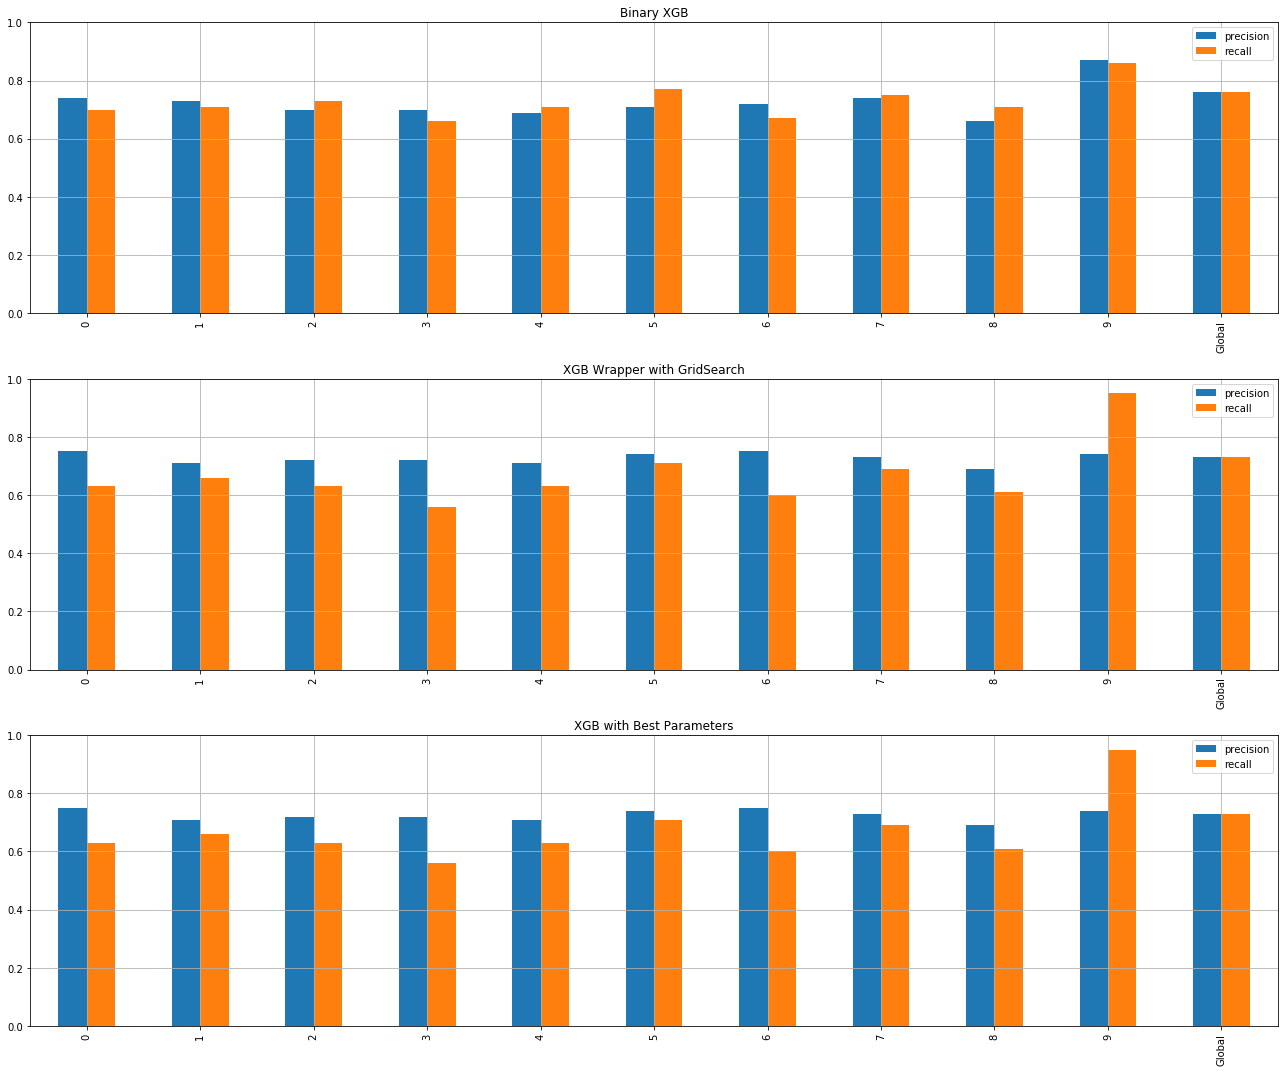

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1)
report_bin[['precision', 'recall']].plot(
    kind='bar',
    title='Binary XGB',
    ylim=(0, 1),
    figsize=(18, 5),
    grid=True,
    ax=ax[0])

report_xgbw[['precision', 'recall']].plot(
    kind='bar',
    title='XGB Wrapper with GridSearch',
    ylim=(0, 1),
    figsize=(18, 5),
    grid=True,
    ax=ax[1])

report_xgb[['precision', 'recall']].plot(
    kind='bar',
    title='XGB with Best Parameters',
    ylim=(0, 1),
    figsize=(18, 5),
    grid=True,
    ax=ax[2])

fig.set_size_inches(18, 3*5)
fig.set_tight_layout('tight')